# Safety Stock Optimization to Provide Desired Service Level for Stochastic Demand

### Inventory Policy:
Inventory policy is a standard operating procedure of implementing an inventory model. Obviously, the inventory model will depend upon the choice of inventory policy adopted. In this particular implementation, the **inventory policy (Q, R)** is used.

Under this policy, the inventory level is continuously monitored. Whenever the inventory level falls below a predefined threshold level (R), also known as **Reorder Point (ROP)**, a replenishment order of fixed quantity (Q), also known as **Economic Order Quantity (EOQ)**, is placed. In this inventory optimization problem, there are two decision variables Q and R.

![](flowdiagram.png)

Inventory optimization requires the answers of two questions:

1. When to purchase (R)?

2. How much to purchase (Q)?

 - **Economic Order Quantity (EOQ):**
The order quantity a company should purchase for its inventory in order to minimize the total costs of inventory-such as holding costs and order costs.


 - **Reorder point (ROP):**
The inventory level at which a new order should be placed.


 - **Lead time:** 
 The delay between the placing of an order and actually receiving the products ordered.


If the demand is perfectly **deterministic**, then ROP can easily be calculated.
<h3><center>ROP = Demand during Lead time</center></h3

![](graph1.png)

If the demand is **stochastic**, then the calculation of ROP is rather complex. If the demand during lead time is less than expected, then there will be inventory on hand when the order is received. But if the demand during lead time is more than expected, then there will be inventory stockouts before the order is received and the service is disrupted. 

In addition, if the lead time also becomes stochastic, then the situation becomes more worse.

<h3><center>ROP = Mean demand during Lead time</center></h3

![](graph2.png)

To prevent inventory stockouts, we keep an addition layer of stock, known as **'safety stock (SS)'** so as to raise the ROP. 

ROP is then calculated as:
<h3><center>ROP = Mean demand during Lead time + SS</center></h3

![](graph3.png)

The calculation of safety stock (SS) depends on service level. Service level is a metric to quantify the level of stockouts that can be tolerated in order to meet the desired level of customer satisfaction. 

If  $\,\alpha = P\,(\text{stockout})$, then the service level is defined as:

$$\text{Service level} = (1-\alpha) = \dfrac{\text{Quantity of products delivered}}{\text{Total quantity demanded}}$$

Besides service level, the amount of **Safety stock (SS)** also depend on

1. Random daily demand denoted by random variable $D_i$, where $i$ indicates the day.

2. Random lead time denoted by random variable $L$.

**Assumptions:**

1. The daily demand $D_i$ is identical and independently distributed (i.i.d) normal variable with $D_i\sim\mathcal{N}(\mu_D, \sigma_D^2)$

2. The lead time $L$ is normal variable with $L\sim\mathcal{N}(\mu_L, \sigma_L^2)$

3. Daily demands are independent of the lead time.

where,
 - $\mu_D$ = Mean value of daily demand
	
 - $\sigma_D^2$ = Variance of daily demand
	
 - $\mu_L$ = Mean value of lead time
	
 - $\sigma_L^2$ = Variance of lead time

<h2><center>Demand Forcasting</center></h2>

In [5]:
import warnings
import itertools
from math import *
import numpy as np
import pandas as pd
from scipy.stats import *
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')
from datetime import datetime

In [3]:
demand_df = pd.read_excel('demand_data.xlsx')
demand_df['Date'] = pd.to_datetime(demand_df['Date'], format='%Y%m%d')
demand_df.set_index('Date', inplace=True)

In [6]:
demand_df.head(3)

,Daily_Demand
Date,
2014-01-01,7
2014-01-02,9
2014-01-03,9


In [4]:
# Resample the demand data in monthly interval
demand_ts = demand_df['Daily_Demand'].resample('MS').mean()
demand_ts.head(10)

Date
2014-01-01    6.741935
2014-02-01    6.642857
2014-03-01    7.419355
2014-04-01    6.500000
2014-05-01    7.096774
2014-06-01    6.066667
2014-07-01    6.774194
2014-08-01    6.580645
2014-09-01    7.166667
2014-10-01    7.032258
Freq: MS, Name: Daily_Demand, dtype: float64

<h3><center>Three Components of a Time Series</center></h3>

 - **Trend:** 
A long-term increase or decrease in the data which might not be linear. Sometimes the trend might change with time.


 - **Seasonality:**
Sometimes a time-series exhibits regular fluctuations based on the season (e.g. every week/month/year). Seasonality is always of a fixed and known period.


 - **Noise/ Residual:** 
The random variation in the time-series after removing the trend and the seasonal component.

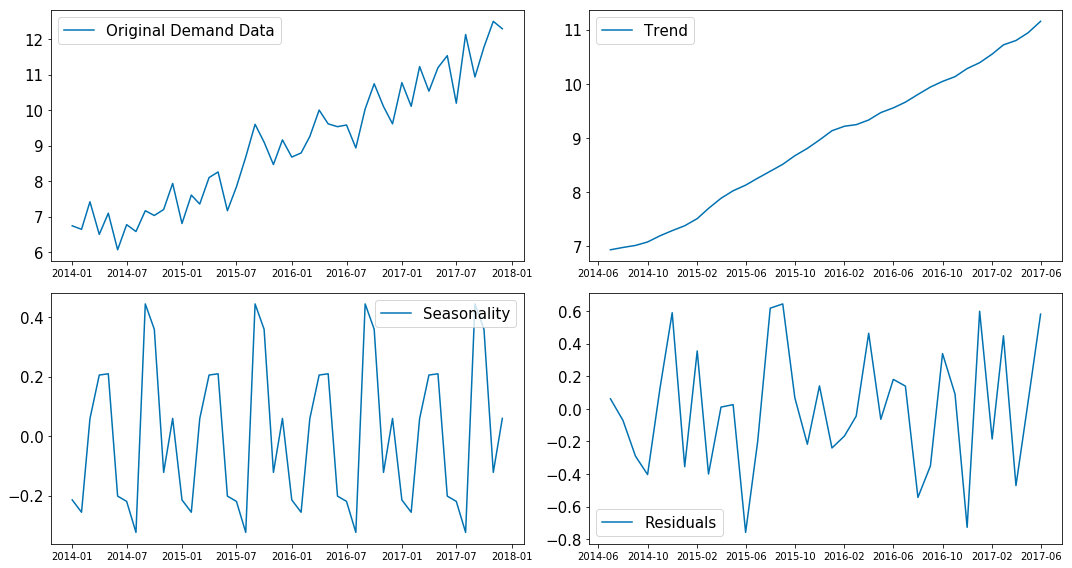

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(demand_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 8))

plt.subplot(2,2,1)
plt.plot(demand_ts, label='Original Demand Data')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tight_layout()

<h2><center>ARIMA Time Series Model</center></h2>

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. There ARIMA models are denoted with the notation **ARIMA$(p, d, q)$** where three distinct integers $(p, d, q)$ are used to parametrize ARIMA models. 


 - $p$ is the **auto-regressive** parameter. It allows us to incorporate the effect of past values into our model. 


 - $d$ is the **integrated** part. This It allows us to incorporate the amount of differencing into the time series. 


 - $q$ is the **moving-average** parameter. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.


When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA $(p,d,q) (P,D,Q)_m$. Here, $(p, d, q)$ are the non-seasonal parameters described above, while $(P, D, Q)$ follow the same definition but are applied to the seasonal component of the time series. The term $m$ is the periodicity of the time series.

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
m = 12
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]

In [7]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(demand_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{};  AIC:{:.4f}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12);  AIC:343.9830
ARIMA(0, 0, 0)x(0, 0, 1, 12);  AIC:1442.2890
ARIMA(0, 0, 0)x(0, 1, 0, 12);  AIC:136.4478
ARIMA(0, 0, 0)x(1, 0, 0, 12);  AIC:88.5373
ARIMA(0, 0, 0)x(1, 0, 1, 12);  AIC:1580.3457
ARIMA(0, 0, 0)x(1, 1, 0, 12);  AIC:80.6137
ARIMA(0, 0, 1)x(0, 0, 0, 12);  AIC:281.8774
ARIMA(0, 0, 1)x(0, 0, 1, 12);  AIC:1381.3964
ARIMA(0, 0, 1)x(0, 1, 0, 12);  AIC:118.6806
ARIMA(0, 0, 1)x(1, 0, 0, 12);  AIC:90.4716
ARIMA(0, 0, 1)x(1, 0, 1, 12);  AIC:1335.4448
ARIMA(0, 0, 1)x(1, 1, 0, 12);  AIC:81.4410
ARIMA(0, 1, 0)x(0, 0, 0, 12);  AIC:108.8672
ARIMA(0, 1, 0)x(0, 0, 1, 12);  AIC:1528.8745
ARIMA(0, 1, 0)x(0, 1, 0, 12);  AIC:101.4313
ARIMA(0, 1, 0)x(1, 0, 0, 12);  AIC:86.8741
ARIMA(0, 1, 0)x(1, 0, 1, 12);  AIC:1498.3693
ARIMA(0, 1, 0)x(1, 1, 0, 12);  AIC:74.7917
ARIMA(0, 1, 1)x(0, 0, 0, 12);  AIC:93.5137
ARIMA(0, 1, 1)x(0, 0, 1, 12);  AIC:1513.7414
ARIMA(0, 1, 1)x(0, 1, 0, 12);  AIC:82.5307
ARIMA(0, 1, 1)x(1, 0, 0, 12);  AIC:78.8707
ARIMA(0, 1, 1)x(1, 0, 1, 12);  AIC

In [8]:
mod = sm.tsa.statespace.SARIMAX(demand_ts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])

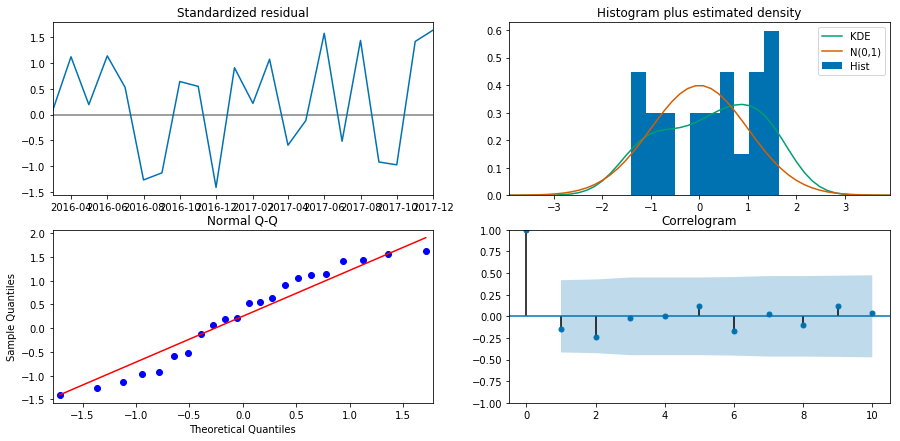

In [9]:
results.plot_diagnostics(figsize=(15, 7))
plt.show()

In [10]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head(10)

,lower Daily_Demand,upper Daily_Demand
Date,,
2017-01-01,8.772706,11.510951
2017-02-01,8.591612,11.321856
2017-03-01,9.121469,11.844984
2017-04-01,9.585159,12.302954
2017-05-01,9.917095,12.629984
2017-06-01,9.093726,11.802377
2017-07-01,9.197003,11.901969
2017-08-01,9.791128,12.492871
2017-09-01,10.215307,12.914217


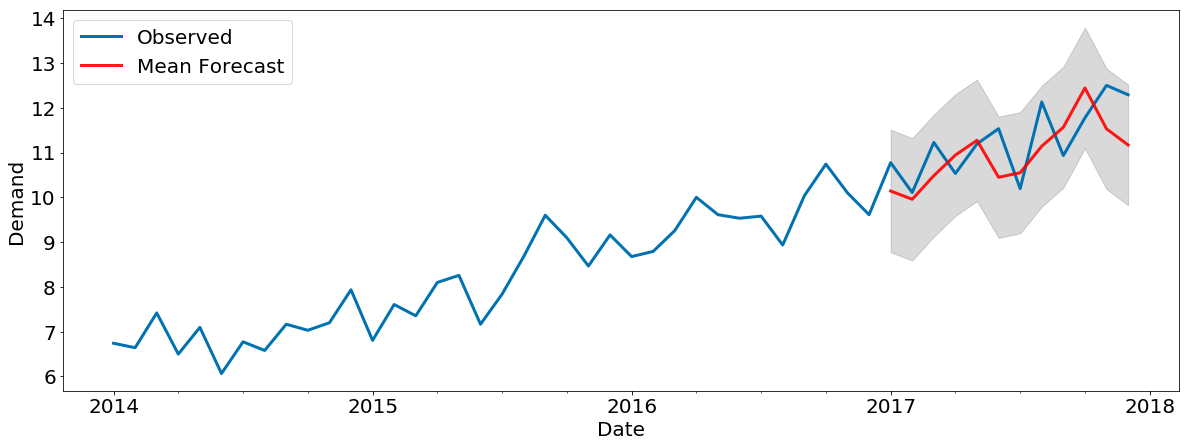

In [11]:
ax = demand_ts['2014':].plot(label='Observed', linewidth = 3, figsize=(20, 7))
pred.predicted_mean.plot(ax=ax, label='Mean Forecast', linewidth = 3, alpha=0.9, color = 'r')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.15)

ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Demand', fontsize = 20)
plt.legend(loc = 'upper left', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('forecast1.png',  dpi = 300)
plt.show()

In [12]:
# Get forecast 12 months ahead in future
forcast_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
forcast_ci = forcast_uc.conf_int()
forcast_ci.head(10)

,lower Daily_Demand,upper Daily_Demand
2018-01-01,10.383226,13.073690
2018-02-01,10.354754,13.155559
2018-03-01,11.042511,13.873404
2018-04-01,11.049833,13.879831
2018-05-01,11.213301,14.046198
2018-06-01,11.364633,14.198301
2018-07-01,10.660282,13.495358
2018-08-01,11.409181,14.245433
2018-09-01,11.267217,14.104723
2018-10-01,12.046721,14.885453


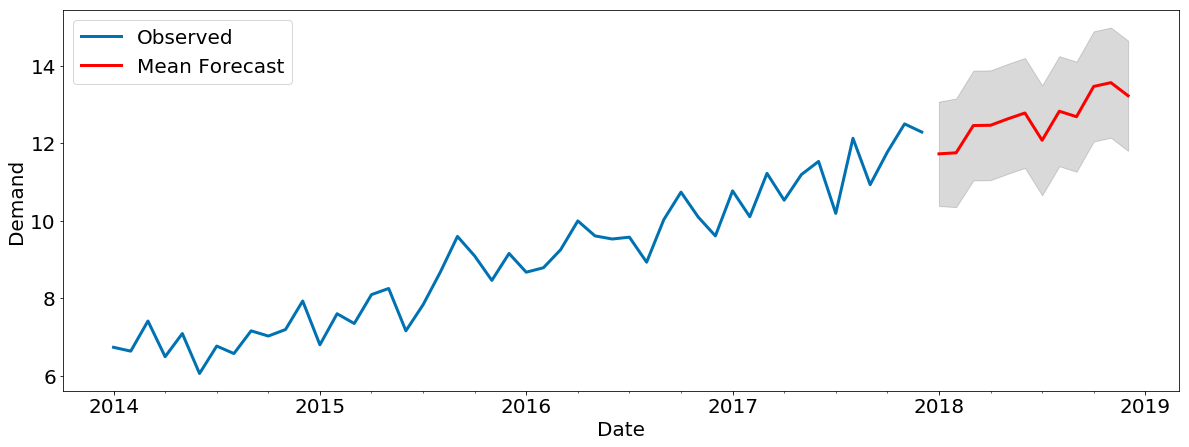

In [13]:
ax = demand_ts.plot(label='Observed', linewidth = 3, figsize=(20, 7))
forcast_uc.predicted_mean.plot(ax=ax, label='Mean Forecast', linewidth = 3,color = 'r')
ax.fill_between(forcast_ci.index,
                forcast_ci.iloc[:, 0],
                forcast_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Demand', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc = 'upper left', fontsize=20)
plt.savefig('forecast2.png',  dpi = 300)
plt.show()

### Find the Mean and Standard Deviation of the forcast demand

Range rule for Standard Deviation:
$\,\,\,\sigma \approx \dfrac{max - min}{4}$

In [14]:
demand_forcast = forcast_ci.copy()
demand_forcast['Mean_Daily_Demand'] = demand_forcast[['lower Daily_Demand', 'upper Daily_Demand']].mean(axis=1)
demand_forcast['Std_Daily_Demand'] = \
demand_forcast.apply(lambda x: (x['upper Daily_Demand'] - x['lower Daily_Demand'])/4, axis=1)
demand_forcast

,lower Daily_Demand,upper Daily_Demand,Mean_Daily_Demand,Std_Daily_Demand
2018-01-01,10.383226,13.073690,11.728458,0.672616
2018-02-01,10.354754,13.155559,11.755157,0.700201
2018-03-01,11.042511,13.873404,12.457957,0.707723
2018-04-01,11.049833,13.879831,12.464832,0.707500
2018-05-01,11.213301,14.046198,12.629750,0.708224
2018-06-01,11.364633,14.198301,12.781467,0.708417
2018-07-01,10.660282,13.495358,12.077820,0.708769
2018-08-01,11.409181,14.245433,12.827307,0.709063
2018-09-01,11.267217,14.104723,12.685970,0.709376
2018-10-01,12.046721,14.885453,13.466087,0.709683


<h2><center>Safety Stock Optimization</center></h2>

In [15]:
# Lead time data from file 
leadtime_df = pd.read_csv("lead_time.csv")
leadtime_list = leadtime_df["lead_time"].tolist()
leadtime_list[:20]

[1, 3, 3, 1, 1, 3, 3, 1, 4, 3, 1, 3, 4, 4, 4, 4, 4, 1, 5, 3]

Calculation of mean and standard deviation of lead time ($\mu_L$ and $\sigma_L$) :

In [16]:
from statistics import mean, stdev

mu_L = mean(leadtime_list)
sigma_L = stdev(leadtime_list)

print('Mean of lead time = {:.3f}'.format(mu_L))
print('Standard Deviation of lead time = {:.3f}'.format(sigma_L))

Mean of lead time = 3.019
Standard Deviation of lead time = 1.306


Mean and standard deviation of demand ($\mu_D$ and $\sigma_D$) :

In [17]:
mu_D = demand_forcast['Mean_Daily_Demand'].tolist()
sigma_D = demand_forcast['Std_Daily_Demand'].tolist()

## Statistics of lead-time demand:
The lead time demand $D_L$, which is a new random variable given by 

$$D_L = \sum_{i=1}^{L}D_i$$
will follow normal distribution with mean and variance given by

$$\mathbb{E}[D_L] = \mathbb{E}\left[\sum_{i=1}^{L}D_i\right] = \mu_L\mu_D, \,\,\,\,Var[D_L] = \mathbb{E}\left[\sum_{i=1}^{L}D_i\right] = \mu_L\sigma_D^2+\mu_D^2\sigma_L^2$$

That is

$$D_L\sim\mathcal{N}(\mu_L\mu_D,\, \mu_L\sigma_D^2+\mu_D^2\sigma_L^2)$$

Economic Order Quantity (EOQ):
----
EOQ is calculated using the following formula:

$$EOQ = \sqrt{\left(\frac{2\mu_Lc_0}{c_h}\right)}$$

where,

$\mu_D = $ Mean value of daily demand, 

$c_0 = $ Fixed ordering cost per order,

$c_h = $ Holding cost per unit quantity per unit time

2018-Jan: EOQ = 53
2018-Feb: EOQ = 53
2018-Mar: EOQ = 55
2018-Apr: EOQ = 55
2018-May: EOQ = 55
2018-Jun: EOQ = 55
2018-Jul: EOQ = 54
2018-Aug: EOQ = 55
2018-Sep: EOQ = 55
2018-Oct: EOQ = 57
2018-Nov: EOQ = 57
2018-Dec: EOQ = 56


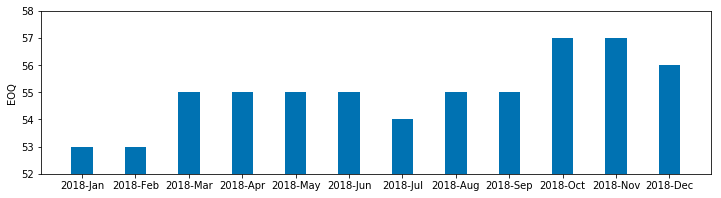

In [19]:
c0 = 12000 # Fixed ordering cost per order
ch = 100 # Holding cost per unit per unit time

EOQ = []
datelist = pd.date_range(demand_forcast.index[0], demand_forcast.index[-1], \
                         freq='MS').strftime("%Y-%b").tolist()
for i, mean_demand_i in enumerate(mu_D):
    #D_L = mean_demand_i*mu_L
    EOQ.append(round(sqrt(2*mean_demand_i*c0/ch)))
    print("{}: EOQ = {}".format(datelist[i], EOQ[-1]))
    
plt.figure(figsize=(12, 3))
plt.bar(np.arange(len(datelist)), EOQ, width = 0.4)
plt.xticks(np.arange(len(datelist)), datelist)
plt.ylim(52, 58)
plt.ylabel('EOQ')
plt.savefig('EOQ.png',  dpi = 300)

## Calculation of Reorder point (ROP) and Safety Stock (SS) for $\,P(\text{No stock-out}) = 1 - \alpha$
For $ (1-\alpha) $ service level, the formula for **safey stock (SS)** is given by:

$$SS = z_{\alpha}\,Var[D_L] = z_{\alpha}\sqrt{\mu_L\sigma_D^2+\mu_D^2\sigma_L^2}$$

where $z_{\alpha}$ is calculated by the relation:

$$Prob\,(z\leq z_{\alpha})=\alpha\,\,\, \text{ where }z\sim\mathcal{N}(0,1)$$<br>

![](z_alf.png)

Once safety stock (SS) is calculated, the **reorder point (ROP)** is then given by:<br>

$$ROP = \mathbb{E}[D_L]+SS$$

$$=\mu_L\mu_D+z_{\alpha}\sqrt{\mu_L\sigma_D^2+\mu_D^2\sigma_L^2}$$

In [20]:
alpha_list = np.linspace(0.90, 0.99, 10)
print(alpha_list)

[0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


In [22]:
SS = [[]]*len(datelist)
ROP = [[]]*len(datelist)
for i, (mean_demand_i, std_demand_i) in enumerate(zip(mu_D, sigma_D)):
    SS_row_i = []
    ROP_row_i = []
    D_L = mean_demand_i*mu_L
    for alpha in alpha_list:
        z_value = norm.ppf(alpha)
        SS_value = z_value*sqrt(mu_L*(std_demand_i**2) + (mean_demand_i**2)*(sigma_L**2))
        SS_row_i.append(round(SS_value))
        
        # Reorder point (ROP) = Expected demand during lead time (D_L) + Safety stock (SS)
        ROP_row_i.append(round(D_L + SS_value))
    
    SS[i] = SS_row_i
    ROP[i] = ROP_row_i

In [23]:
# Safety stock (SS)
SS_df = pd.DataFrame(SS)
SS_df.columns = [r'$\alpha$ = {:.2f}'.format(x) for x in alpha_list]
SS_df.index = datelist
SS_df

,$\alpha$ = 0.90,$\alpha$ = 0.91,$\alpha$ = 0.92,$\alpha$ = 0.93,$\alpha$ = 0.94,$\alpha$ = 0.95,$\alpha$ = 0.96,$\alpha$ = 0.97,$\alpha$ = 0.98,$\alpha$ = 0.99
2018-Jan,20.0,21.0,22.0,23.0,24.0,25.0,27.0,29.0,32.0,36.0
2018-Feb,20.0,21.0,22.0,23.0,24.0,25.0,27.0,29.0,32.0,36.0
2018-Mar,21.0,22.0,23.0,24.0,25.0,27.0,29.0,31.0,34.0,38.0
2018-Apr,21.0,22.0,23.0,24.0,25.0,27.0,29.0,31.0,34.0,38.0
2018-May,21.0,22.0,23.0,24.0,26.0,27.0,29.0,31.0,34.0,38.0
2018-Jun,21.0,22.0,24.0,25.0,26.0,28.0,29.0,31.0,34.0,39.0
2018-Jul,20.0,21.0,22.0,23.0,25.0,26.0,28.0,30.0,32.0,37.0
2018-Aug,22.0,23.0,24.0,25.0,26.0,28.0,29.0,32.0,34.0,39.0
2018-Sep,21.0,22.0,23.0,25.0,26.0,27.0,29.0,31.0,34.0,39.0
2018-Oct,23.0,24.0,25.0,26.0,27.0,29.0,31.0,33.0,36.0,41.0


In [24]:
# Reorder Point (ROP)
ROP_df = pd.DataFrame(ROP)
ROP_df.columns = [r'$\alpha$ = {:.2f}'.format(x) for x in alpha_list]
ROP_df.index = datelist
ROP_df

,$\alpha$ = 0.90,$\alpha$ = 0.91,$\alpha$ = 0.92,$\alpha$ = 0.93,$\alpha$ = 0.94,$\alpha$ = 0.95,$\alpha$ = 0.96,$\alpha$ = 0.97,$\alpha$ = 0.98,$\alpha$ = 0.99
2018-Jan,55.0,56.0,57.0,58.0,59.0,61.0,62.0,64.0,67.0,71.0
2018-Feb,55.0,56.0,57.0,58.0,59.0,61.0,62.0,64.0,67.0,71.0
2018-Mar,59.0,59.0,61.0,62.0,63.0,64.0,66.0,68.0,71.0,76.0
2018-Apr,59.0,60.0,61.0,62.0,63.0,64.0,66.0,68.0,71.0,76.0
2018-May,59.0,60.0,61.0,63.0,64.0,65.0,67.0,69.0,72.0,77.0
2018-Jun,60.0,61.0,62.0,63.0,65.0,66.0,68.0,70.0,73.0,78.0
2018-Jul,57.0,58.0,59.0,60.0,61.0,62.0,64.0,66.0,69.0,73.0
2018-Aug,60.0,61.0,62.0,64.0,65.0,66.0,68.0,70.0,73.0,78.0
2018-Sep,60.0,61.0,62.0,63.0,64.0,66.0,67.0,70.0,72.0,77.0
2018-Oct,63.0,64.0,65.0,67.0,68.0,70.0,72.0,74.0,77.0,82.0


### Plotting SS and ROP in a chart

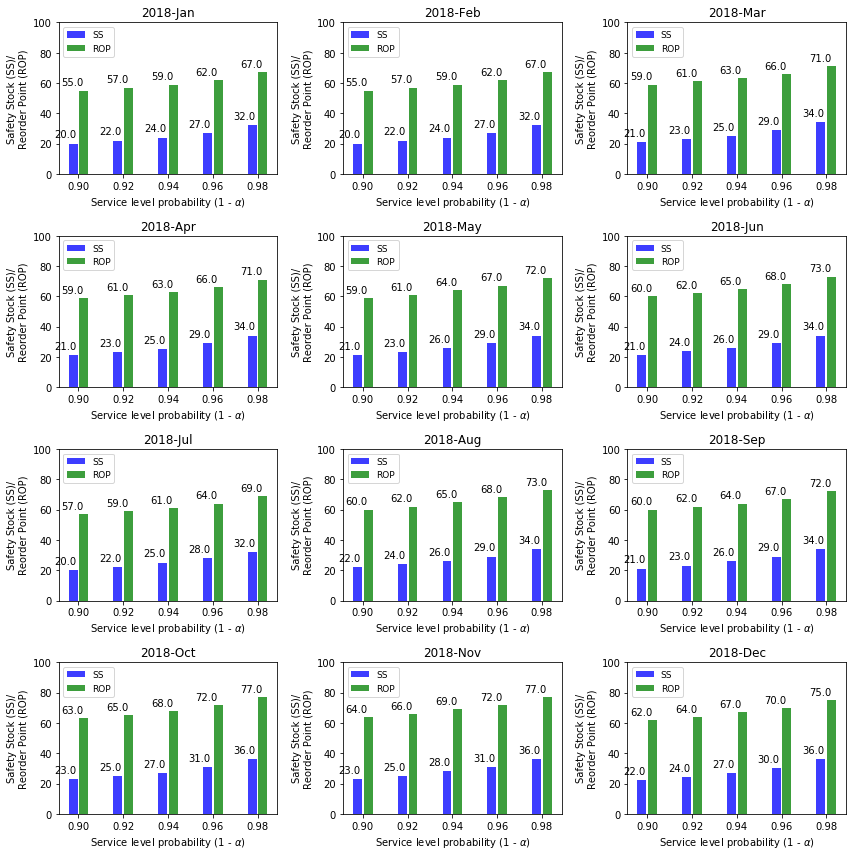

In [25]:
fig1 = plt.figure(figsize=(12, 12))
#colors = ['b', 'r', 'g', 'm']*len(datelist)
skip = 2
for i in range(len(datelist)):

    SS_monthly_list = SS_df.iloc[i,:].tolist()
    ROP_monthly_list = ROP_df.iloc[i,:].tolist()

    ax = plt.subplot(4,3,i+1)
#     plt.plot(alpha_list, SS_monthly_list, 'bD-', label = 'Safety Stock (SS)', linewidth = 1.5)
#     plt.plot(alpha_list, ROP_monthly_list, 'go-', label = 'Reorder Point (ROP)', linewidth = 1.5)
    
    ax.bar(alpha_list[::skip]-0.0012*skip, SS_monthly_list[::skip], width=0.002*skip, color='b',\
           align='center', label = 'SS', alpha = 0.76)
    ax.bar(alpha_list[::skip]+0.0012*skip, ROP_monthly_list[::skip], width=0.002*skip, color='g',\
           align='center',label = 'ROP', alpha = 0.76)
    
    for x, y, z in zip(alpha_list[::skip], SS_monthly_list[::skip], ROP_monthly_list[::skip]):
        plt.annotate(y, xy=(x, y), xytext=(-2, 4),\
            textcoords='offset points', ha='right', va='bottom')
        plt.annotate(z, xy=(x, z), xytext=(5, 3),\
            textcoords='offset points', ha='right', va='bottom')

    plt.xlabel('Service level probability (1 - $\\alpha$)', fontsize = 10)
    plt.ylabel('Safety Stock (SS)/'+'\n'+'Reorder Point (ROP)', fontsize = 10)
    plt.ylim(0, 100)
    plt.legend(loc = 'upper left', fontsize = 9)
    ax.set_title(datelist[i])

plt.tight_layout()
plt.show()